In [23]:
from fastai2.vision.all import *
from faststyle import *
from nbdev.showdoc import *

In [2]:
source = untar_data(URLs.COCO_SAMPLE)

In [3]:
fns = get_image_files(source)

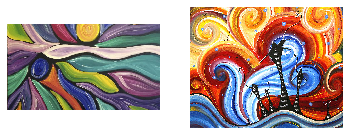

In [4]:
style_dir = Path('styles')
style_fns = L('abstract.jpg', 'village.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [5]:
class Weights(TensorBase, ShowTitle):
  _show_args = {'label': 'weights'}
  @classmethod
  def create(cls, x):  return cls(x)

In [6]:
def random_weights(*size):
  x = torch.rand(*size)
  return x / x.sum()

In [7]:
class WeightsCallback(Callback):
  def after_pred(self):
    if len(self.yb) == 0: return 
    self.yb[1]['ws'] = self.xb[0].ws

In [8]:
class ImageWeight(Tuple):
  def show(self, ctx=None, **kwargs):
    return show_titled_image(self, ctx=ctx, **kwargs)
  
  @classmethod
  def create(cls, fn, ws=None, imcls=PILImageX): return cls(imcls.create(fn), Weights(ifnone(ws, [1.])))
ImageWeight.im, ImageWeight.ws = add_props(lambda i,x: x[i])

In [9]:
imw = ImageWeight.create(fns[0], [.8, .2])
explode_types(imw)

{__main__.ImageWeight: [faststyle.data.PILImageX, __main__.Weights]}

In [10]:
class RandomizeWeights(RandTransform):
  def encodes(self, x:Weights):
    x.data = random_weights(*x.shape)
    return x

In [11]:
@typedispatch
def show_batch(x:ImageWeight, y:TensorImage, samples, **kwargs):
  return show_batch.funcs[TensorImage][TensorImage](x, y, samples, **kwargs)

In [28]:
show_results.funcs[TensorImage][TensorImage]

<function fastai2.vision.learner.show_results(x: fastai2.torch_core.TensorImage, y: fastai2.torch_core.TensorImage, samples, outs, ctxs=None, max_n=10, figsize=None, **kwargs)>

In [31]:
@typedispatch
def show_results(x:ImageWeight, y:TensorImage, samples, outs, **kwargs):
  return show_results.funcs[TensorImage][TensorImage](x, y, samples, outs, **kwargs)

In [12]:
def get_items(path, n=2):
  fns = get_image_files(source)
  return fns.map(lambda o: [o, random_weights(n)])

In [13]:
dset = Datasets(get_items(source), splits=RandomSplitter()(fns),
                tfms=[[lambda o: ImageWeight.create(*o)], [itemgetter(0), PILImage.create]])

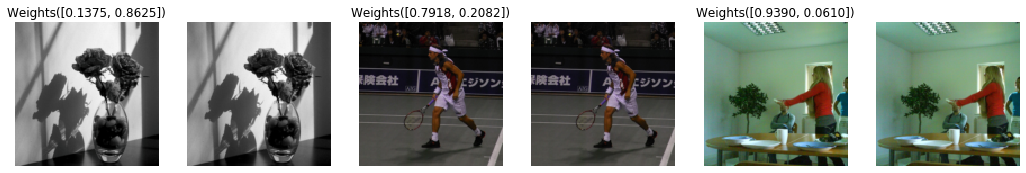

In [14]:
dls = dset.dataloaders(bs=16,
                       after_item=[ToTensor(), Resize(128), RandomizeWeights],
                       after_batch=[IntToFloatTensor, NormalizeX.from_stats(*coco_stats)])
dls.show_batch(max_n=3)

In [15]:
xb,yb = dls.one_batch()

In [16]:
layer_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [17]:
loss_func = FastStyleLoss()
cbs = [FeatsCallback.from_fns(style_fns, layer_feats), WeightsCallback()]
learn = Learner(dls, TransformerNet2(2), loss_func, cbs=cbs, metrics=loss_func.metrics)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,stl,cnt,tv,time


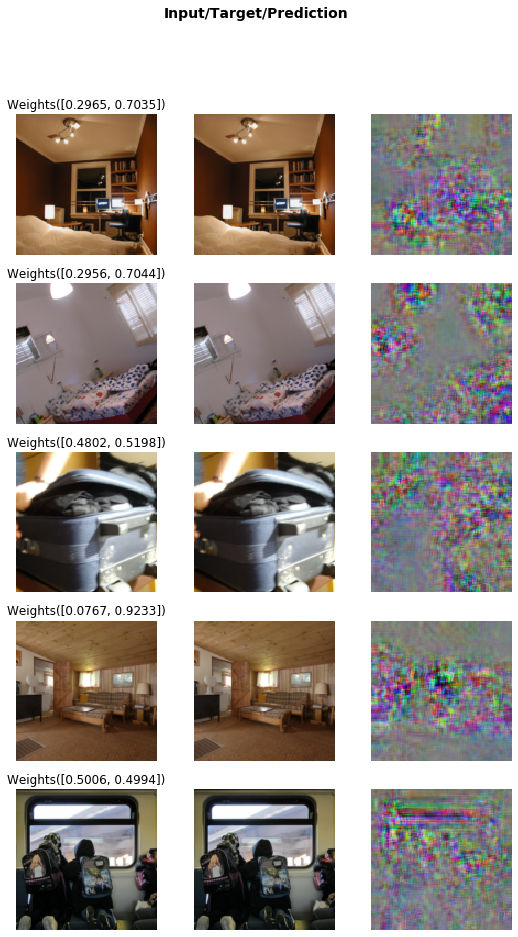

In [32]:
learn.show_results()